In [2]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
import sklearn
from sklearn.preprocessing import KBinsDiscretizer

In [8]:
# Adding KBM value to df
users = pd.read_csv('C:/Users/sgulbin/Work/Analysis/DataQualityAnalysis/original_data/users_activated_v6.csv', low_memory = False)
users = users[['user_id', 'login', 'sex', 'birthday', 'license_set_date']]
kbm = pd.read_csv('C:/Users/sgulbin/Work/Scoring (Accidents)/2020-03Test_v2/KBM_data/KBM_data_4_13_2020.csv')
kirill = pd.read_csv('C:/Users/sgulbin/Work/Scoring (Accidents)/2020-03Test_v2/november_users.csv', delimiter = ';')
# df = pd.merge(pd.merge(kirill,users,on = 'user_id', how = 'left'), kbm, on = 'user_id', how = 'left')
df = pd.merge(users, kbm, on = 'user_id', how = 'left')
df['age'] = np.clip((pd.to_datetime('today')-pd.to_datetime(df.birthday, errors = 'coerce')).astype('timedelta64[Y]'),19.0,80.0)
df['exp'] = np.clip((pd.to_datetime('today')-pd.to_datetime(df.license_set_date, errors = 'coerce')).astype('timedelta64[Y]'),1.0,62.0)
df['sex'] = df['sex'].fillna('Unknown')
print(df)

            user_id        login sex    birthday license_set_date  user_ext  \
0          19500003  79030926325   М  1987-09-19       2013-01-01      33.0   
1          19500005  79151785151   М  1978-03-25       1999-01-01      64.0   
2          19500006  79165352352   М  1987-05-23              NaN      68.0   
3          19500013  79853423032   М  1982-06-28       2000-01-01      93.0   
4          19500018  79057495722   М  1984-04-22       2003-01-01       NaN   
...             ...          ...  ..         ...              ...       ...   
1837982  1172750201  79211725405   М  1991-12-27       2011-01-01       NaN   
1837983  1172750208  79051594640   Ж  1990-04-14       2014-01-01       NaN   
1837984  1172750222  79372024021   М  1990-09-19       2010-01-01       NaN   
1837985  1172750252  79046316317   М  1970-02-01       2003-01-01       NaN   
1837986  1172750299  79217466114   М  1982-08-30       2003-01-01       NaN   

         KBM   age   exp  
0        1.0  32.0   7.0

In [9]:
# Generating age-exp coefficients
K_age_exp_max = 1.2
K_age_exp_min = 0.725
K_intercept = -4.88430556234637
K_f_age = 1.26397937674965
K_f_exp = 0.0762464696907463
f_age_exp_min = K_f_age*np.log(19)+K_f_exp*np.log(1)+K_intercept
f_age_exp_max = K_f_age*np.log(50)+K_f_exp*np.log(20)+K_intercept
K = K_age_exp_max-((K_f_age*np.log(19)+K_f_exp*np.log(1)+K_intercept)-f_age_exp_min)*(K_age_exp_max-K_age_exp_min)/(f_age_exp_max-f_age_exp_min)
ages = []
exps = []
koefs = []
for age in range(19,101):
    for exp in range(1,83):
        K = np.clip(K_age_exp_max-((K_f_age*np.log(age)+K_f_exp*np.log(exp)+K_intercept)-f_age_exp_min)*(K_age_exp_max-K_age_exp_min)/(f_age_exp_max-f_age_exp_min),K_age_exp_min,K_age_exp_max)
        ages.append(age)
        exps.append(exp)
        koefs.append(K)
age_exp_df = pd.DataFrame(data = ({'age':ages, 'exp':exps, 'K_age_exp': koefs}))
# print(age_exp_df)

In [10]:
# Adding coefficients to df
df_K_sex = pd.DataFrame(data = ({'sex': ['М', 'Ж', 'Unknown'], 'K_sex': [1.0,1.10,1.0]}))
df_K_KBM = pd.DataFrame(data = ({'KBM': [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.4,1.55,2.3,2.45,np.nan],
                                 'K_KBM': [0.9,0.9,0.9,0.9,0.9,0.9,0.95,0.95,1.0,1.0,1.03,1.1,1.1,1.1,1.1,1.03]}))
df = pd.merge(df, df_K_sex, how = 'left', left_on = 'sex', right_on = 'sex')
df = pd.merge(df, df_K_KBM, how = 'left', left_on = 'KBM', right_on = 'KBM')
df = pd.merge(df, age_exp_df, how = 'left', left_on = ['age','exp'], right_on = ['age','exp'])
df['K_age_exp'] = np.where(df['age'].isnull(), 1.0, np.where(df['exp'].isnull(),1.0,np.where((df['age']-df['exp'])<16,1.0,df['K_age_exp'])))
df['K_age_exp'] = df['K_age_exp'].fillna(1.0)
df['K_KBM'] = df['K_KBM'].fillna(1.0)
df['K_KBM_model_score'] = np.clip(df.K_sex*df.K_KBM*df.K_age_exp,0.7,1.3)

In [14]:
# Creating KBM_model_coefficient to KBM_model score mapping. Percentiles

est = KBinsDiscretizer(n_bins=103, encode='ordinal', strategy='quantile')
est.fit(df[['K_KBM_model_score']])
Xt = est.transform(df[['K_KBM_model_score']])
df['percentile'] = Xt
to_kirill = df[['user_id','K_KBM_model_score', 'percentile']]
to_kirill['percentile2'] = abs((to_kirill['percentile']-100.0)/100.0)
to_kirill = to_kirill[['user_id', 'K_KBM_model_score', 'percentile2']]
to_kirill.to_csv('C:/Users/sgulbin/Work/Scoring (Accidents)/2020-03Test_v2/KBM_score_to_Kirill_v5.csv')

# Creating mapping
mapping = to_kirill.groupby('percentile2').min()
grpd_max = to_kirill.groupby('percentile2').max()
mapping['max'] = grpd_max.K_KBM_model_score
mapping = mapping[['K_KBM_model_score', 'max']]
mapping.columns = ['min', 'max']
mapping.to_csv('C:/Users/sgulbin/Work/Scoring (Accidents)/2020-03Test_v2/FTR_score_mapping_v5.csv')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


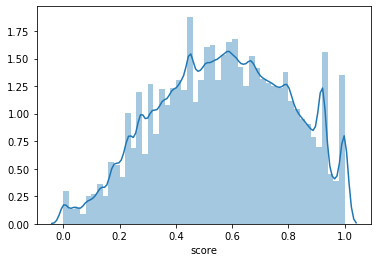

In [18]:
# Plotting score distribution
df['score'] = (df.K_KBM_model_score-df.K_KBM_model_score.max())/(df.K_KBM_model_score.min()-df.K_KBM_model_score.max())
sns.distplot(df.score)